# 13-9. 프로젝트 : 주식 예측에 도전해 보자

### [루브릭]
1. 시계열의 안정성이 충분히 확인되었는가?
    - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
    
    
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
    
    
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    - 3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨


### [학습 과정]
1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기

### [결론 및 회고]

## 1. 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음.
* 우리는 Close만 사용할 예정. (주식 시장은 정해진 시간 동안만 거래가 가능함. 종가란 하루의 장이 마감하였을 때의 가격.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/E13_TimeSeriesPrediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']    # 종가만 가져옵니다

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
2020-03-02    55000.0
2020-03-03    55400.0
Name: Close, dtype: float64

## 2. 각종 전처리 수행

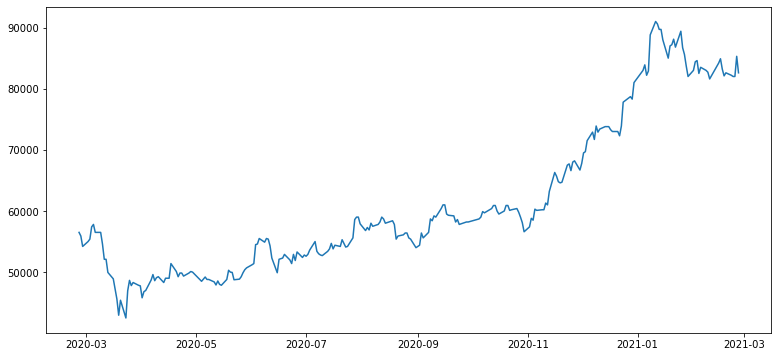

In [2]:
# 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

이미 date 컬럼으로 인덱싱이 되어있기 때문에 따로 인덱스 처리를 해줄 필요는 없습니다. 결측치 유무를 확인하고 있다면 time을 기준으로 선택하여 보간해 줍니다.

In [3]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
# 로그변환 - 시간 추이에 따라 분산이 점점 커지고 있을 때는 로그변환을 해주면 좋습니다.
ts_log = np.log(ts)

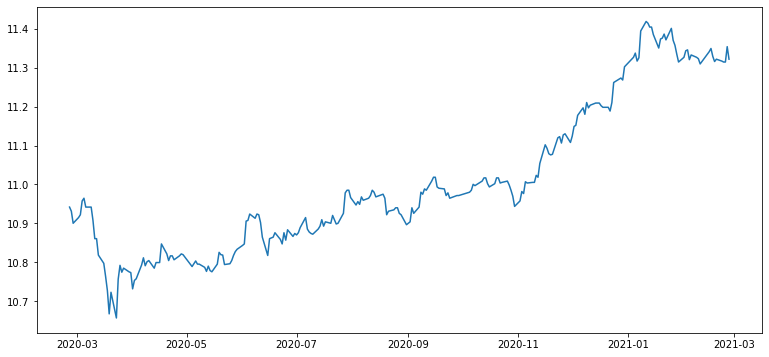

In [5]:
plt.plot(ts_log)

흠 그닥 안정적인 추이를 보이고 있지는 않습니다. 

## 3. 시계열 안정성 분석

In [6]:
# 일정 시간 내 구간 통계치를 시각화해보기

def plot_rolling_statistics(timeseries, window=12):
    
    # 현재 타임스텝 ~ window에 주어진 타임스텝 이전 사이 구간의 평균, 표준편차
    rolmean = timeseries.rolling(window=window).mean()       # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std()         # 이동 표준편차 시계열
    
    # 원본 시계열, 이동 평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

정성적 그래프 분석

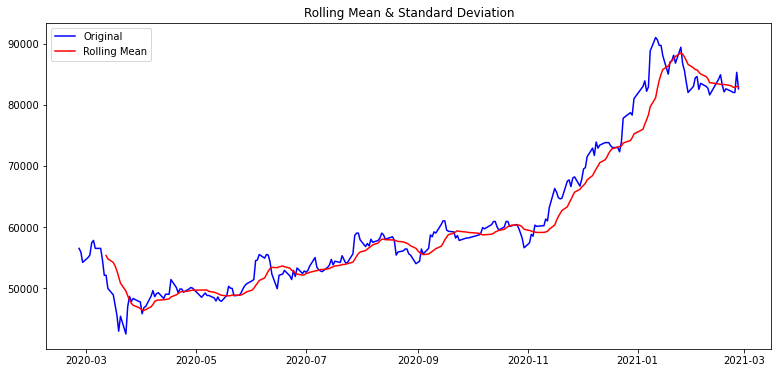

In [7]:
plot_rolling_statistics(ts, window=12)

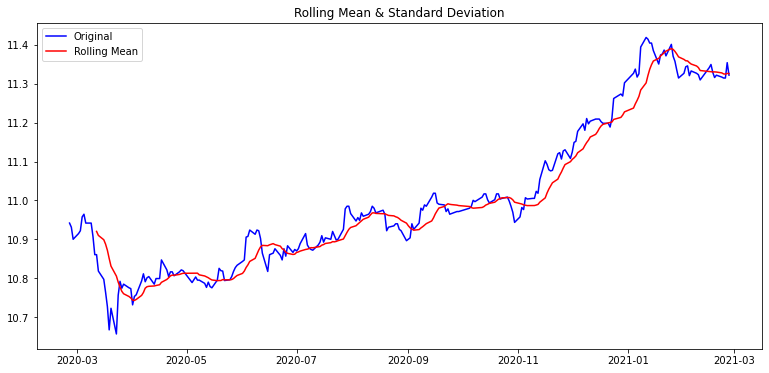

In [8]:
plot_rolling_statistics(ts_log, window=12)

### Stationary 여부 체크하기

#### 1. Augmented Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

In [10]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.065519
p-value                          0.963627
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [11]:
augmented_dickey_fuller_test(ts_log)     # log 변환한 것이 약간 미세하게 pvalue값이 낮군요

Results of Dickey-Fuller Test:
Test Statistic                  -0.050436
p-value                          0.954157
#Lags Used                       1.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


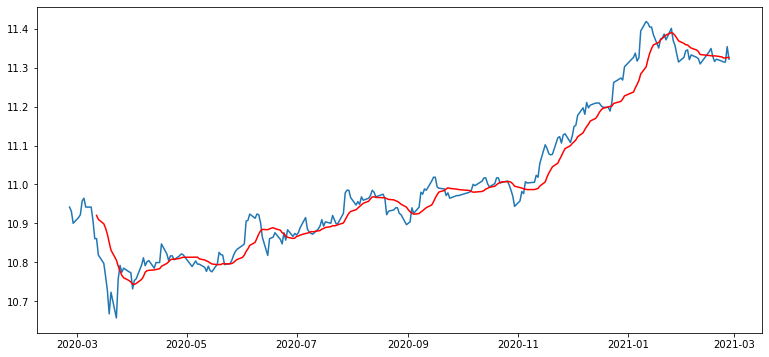

In [12]:
# 추세 상쇄하기 : Moving Average(rolling mean)을 구해서 ts_log에서 빼줍니다

moving_avg = ts_log.rolling(window=12).mean()      
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg = ts_log - moving_avg  # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-02-26         NaN
2020-02-27         NaN
2020-02-28         NaN
2020-03-02         NaN
2020-03-03         NaN
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12   -0.059691
2020-03-13   -0.091566
2020-03-16   -0.101662
2020-03-17   -0.123581
Name: Close, dtype: float64

In [14]:
# window size가 12이면 앞의 11개 데이터는 계산되지 않기 때문에 그로 인해 생기는 결측치를 제거해줍니다.

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(10)

Date
2020-03-12   -0.059691
2020-03-13   -0.091566
2020-03-16   -0.101662
2020-03-17   -0.123581
2020-03-18   -0.144565
2020-03-19   -0.183224
2020-03-20   -0.108205
2020-03-23   -0.148589
2020-03-24   -0.033580
2020-03-25    0.014454
Name: Close, dtype: float64

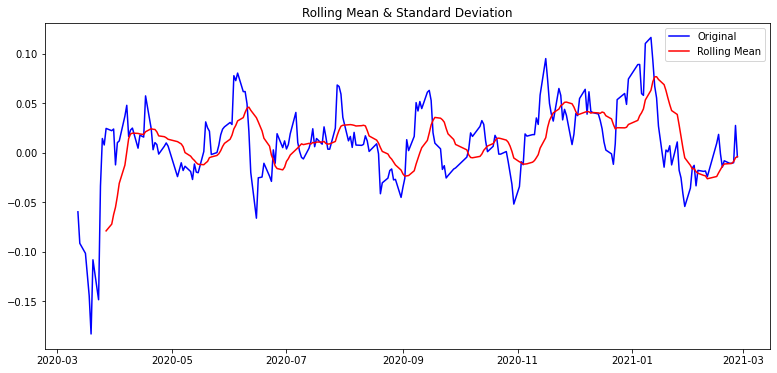

In [15]:
# 정성, 정량적 분석하기

plot_rolling_statistics(ts_log_moving_avg)

In [16]:
augmented_dickey_fuller_test(ts_log_moving_avg)      # 헐 pvalue 엄청 줄어들음

Results of Dickey-Fuller Test:
Test Statistic                  -4.239506
p-value                          0.000564
#Lags Used                       0.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [17]:
# 만약 window = 6이라면?
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

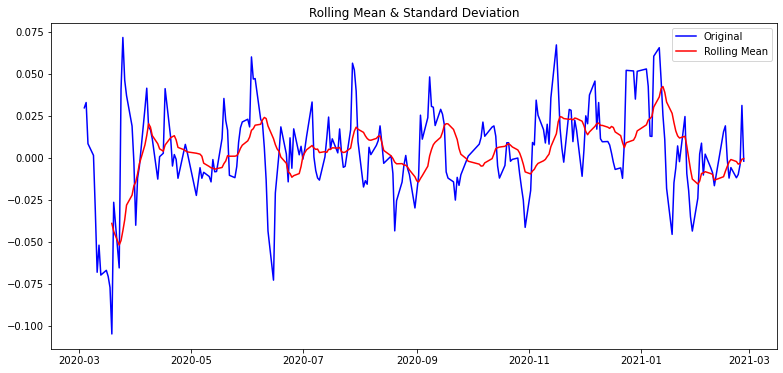

In [18]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [19]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)     

# 더 안정적이네요 6개월 단위로 주기를 나눠야 하나

Results of Dickey-Fuller Test:
Test Statistic                -6.805340e+00
p-value                        2.184014e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


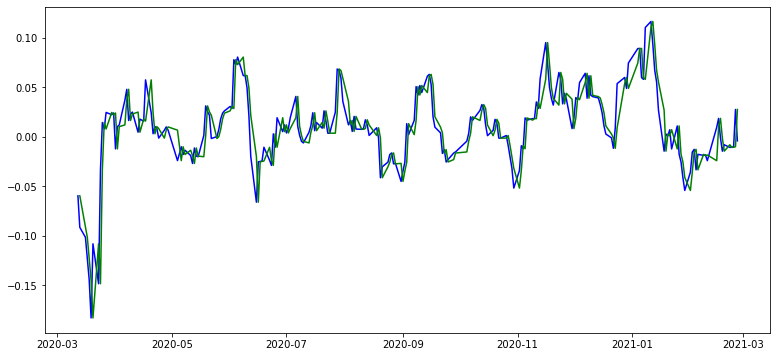

In [20]:
# 차분 - 계절성 상쇄하기

ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

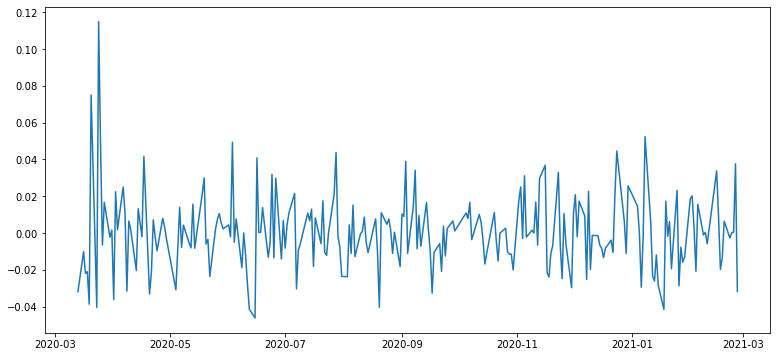

In [21]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

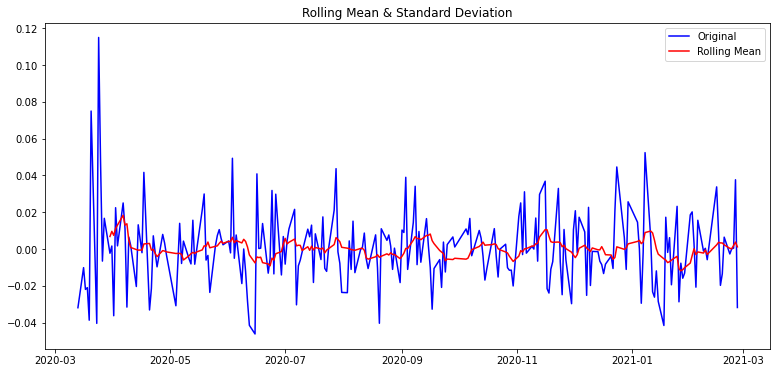

In [22]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff) # pvalue가 더 줄어들었네요

Results of Dickey-Fuller Test:
Test Statistic                -1.608011e+01
p-value                        5.389915e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


In [24]:
# 6개월 주기인 것도 차분해볼까

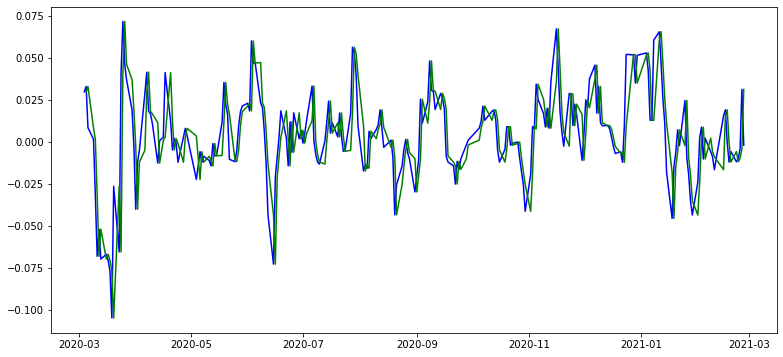

In [25]:
ts_log_moving_avg_shift_6 = ts_log_moving_avg_6.shift()

plt.plot(ts_log_moving_avg_6, color='blue')
plt.plot(ts_log_moving_avg_shift_6, color='green')

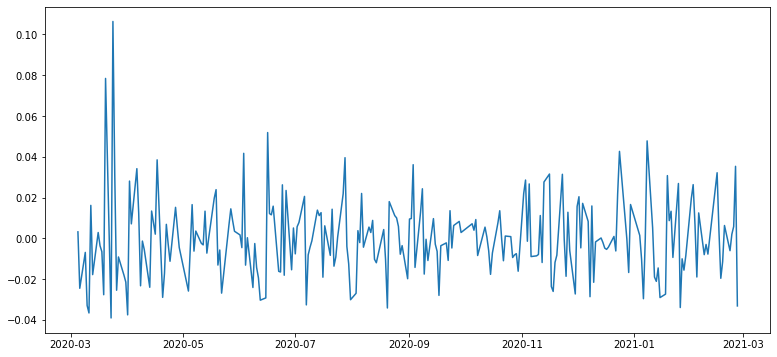

In [26]:
ts_log_moving_avg_diff_6 = ts_log_moving_avg_6 - ts_log_moving_avg_shift_6
ts_log_moving_avg_diff_6.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff_6)

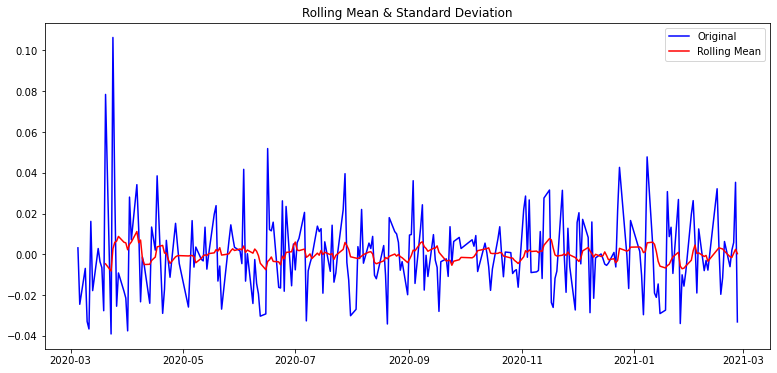

In [27]:
plot_rolling_statistics(ts_log_moving_avg_diff_6)

In [28]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff_6) # 얘도 pvalue가 더 줄어들었네요

Results of Dickey-Fuller Test:
Test Statistic                -6.841129e+00
p-value                        1.790103e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


## 시계열 분해
 
 앞서 한 것들은 전체적인 흐름을 따라오기 위해 한 과정입니다. 이것을 한번에 구현해보겠습니다.

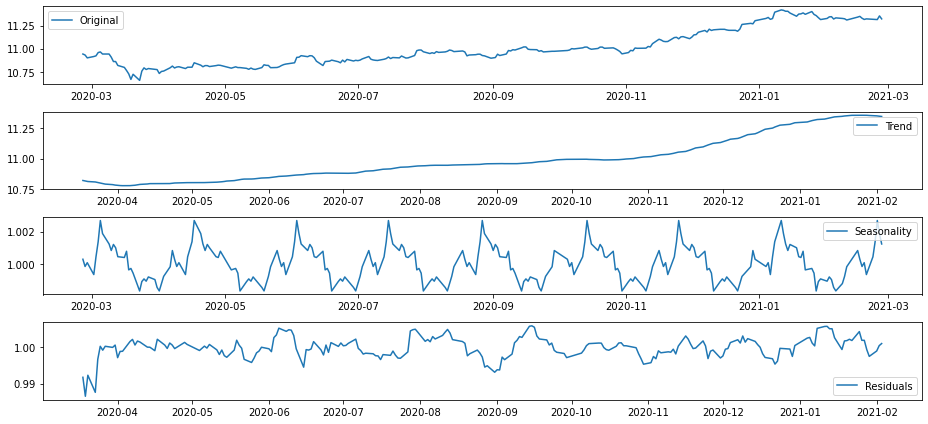

In [29]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')        # Residual = trend와 Seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

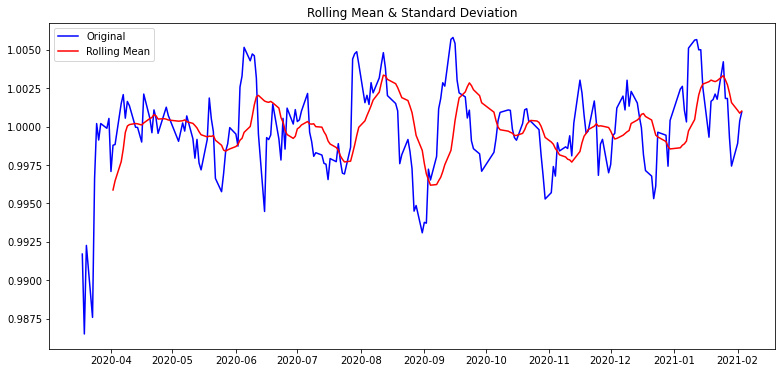

In [30]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.434632
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

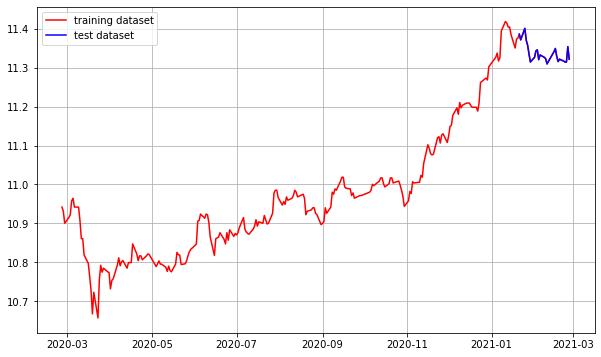

In [32]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [33]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-02-26    10.941996
2020-02-27    10.931320
Name: Close, dtype: float64
(224,)
(25,)


## 5. 적정 ARIMA 모수 찾기

### ACF, PACF 그려보기 -> p, q 구하기

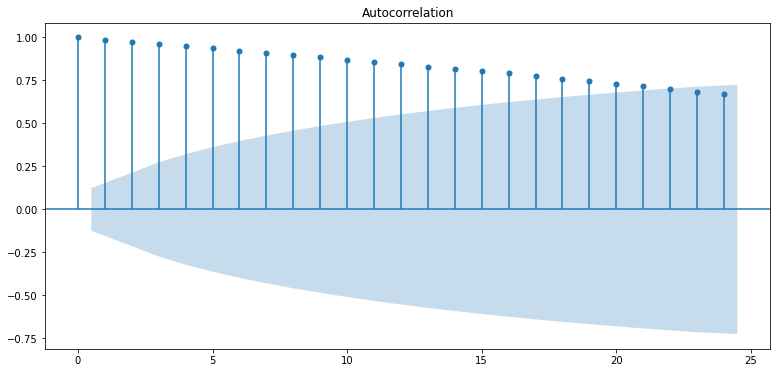

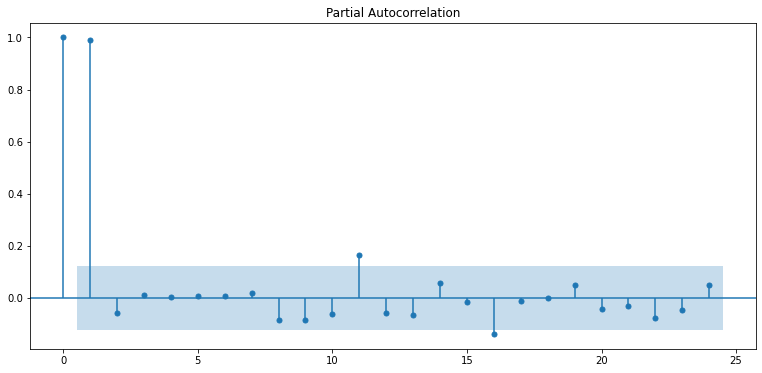

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 보면,MA모델의 시차 p는 p = 1이 적합한것같습니다.    
ACF 그래프는 점차적으로 감소하고 있어서 AR(1) 모델에 유사합니다. q에 대해서는 적합한 값이 없습니다. q = 0으로 일단 둬보고 바꿔가면서 확인해보겠습니다. 

### 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.615303e+01
p-value                        4.548400e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


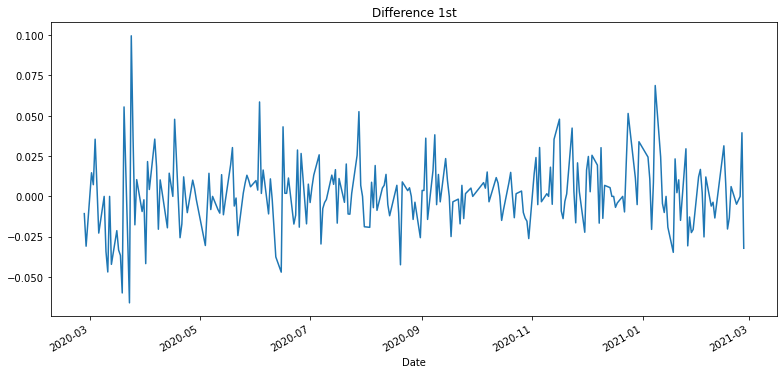

In [35]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.632688e+00
p-value                        1.989501e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


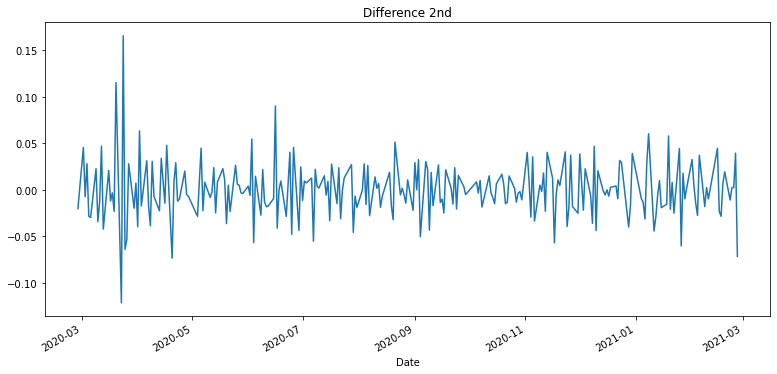

In [36]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분을 구한 결과, 1차 차분만으로도 안정화 상태를 보입니다. 따라서 우선 d=1로 시도해보고 값을 바꿔보면서 최적의 값을 찾아보겠습니다.

## 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

### p,d,q = 1,1,*

In [37]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 539.574
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 02 Mar 2021   AIC                          -1073.149
Time:                        02:44:49   BIC                          -1062.927
Sample:                             1   HQIC                         -1069.022
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.001      1.378      0.168      -0.001       0.005
ar.L1.D.Close    -0.0201      0.067     -0.300      0.764      -0.151       0.111
                                    Root

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

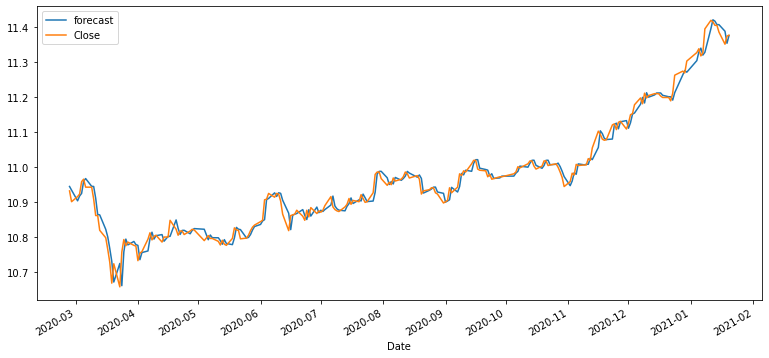

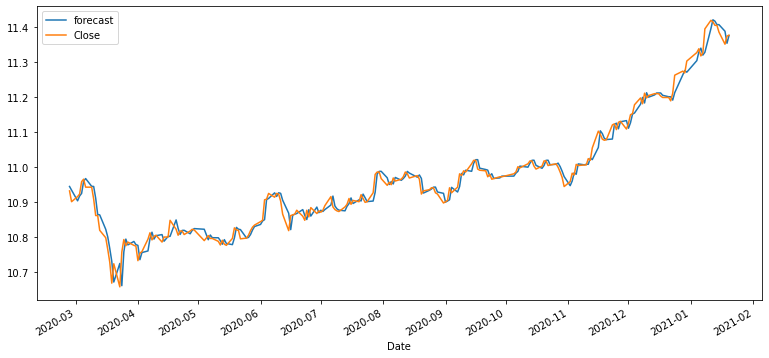

In [38]:
fitted_m.plot_predict()

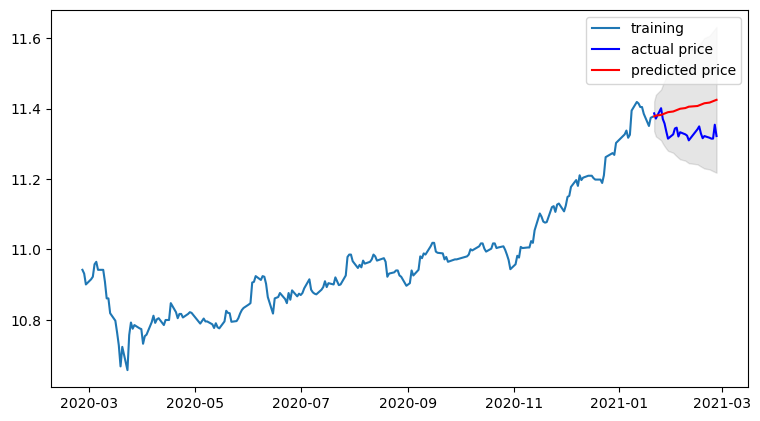

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  39107030.57378085
MAE:  5689.243548528282
RMSE:  6253.561431199093
MAPE: 6.85%


### 미래 주식을 예측해보자

In [41]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
print(final_data)


                    0
2021-01-21  11.386228
2021-01-22  11.371362
2021-01-25  11.400876
2021-01-26  11.370209
2021-01-27  11.357441
2021-01-28  11.334994
2021-01-29  11.314475
2021-02-01  11.326596
2021-02-02  11.343323
2021-02-03  11.345690
2021-02-04  11.320554
2021-02-05  11.332602
2021-02-08  11.326596
2021-02-09  11.322975
2021-02-10  11.309585
2021-02-15  11.340950
2021-02-16  11.349229
2021-02-17  11.329003
2021-02-18  11.315693
2021-02-19  11.321765
2021-02-22  11.316911
2021-02-23  11.314475
2021-02-24  11.314475
2021-02-25  11.353930
2021-02-26  11.321765
2021-02-27        NaN
2021-02-28        NaN
2021-03-01        NaN
2021-03-02        NaN
2021-03-03        NaN
2021-03-04        NaN
2021-03-05        NaN
2021-03-06        NaN
2021-03-07        NaN
2021-03-08        NaN
2021-03-09        NaN
2021-03-10        NaN
2021-03-11        NaN
2021-03-12        NaN
2021-03-13        NaN
2021-03-14        NaN
2021-03-15        NaN
2021-03-16        NaN
2021-03-17        NaN
2021-03-18

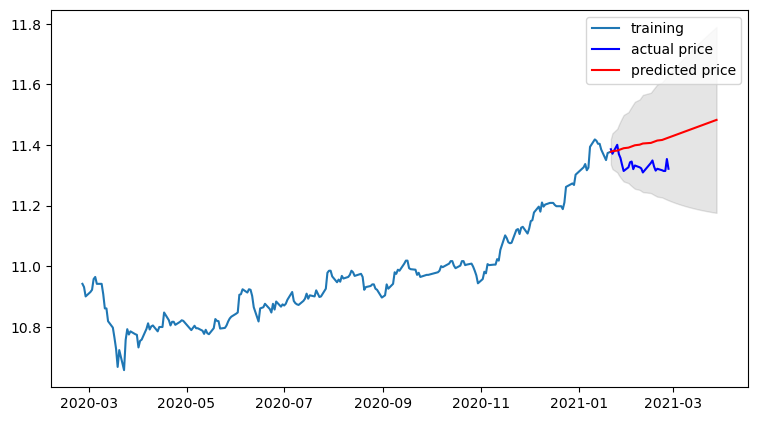

In [42]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [43]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound

In [44]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])

fore_series

,Close
2021-02-27,87369.340230
2021-02-28,87539.635524
2021-03-01,87710.250144
2021-03-02,87881.197546
2021-03-03,88052.478120
2021-03-04,88224.092519
2021-03-05,88396.041395
2021-03-06,88568.325400
2021-03-07,88740.945187
2021-03-08,88913.901410


MAPE 기준으로 6.85%의 오차율을 보입니다. q 값을 변경해서 오차율을 더 줄여보겠습니다.

In [45]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 539.539
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 02 Mar 2021   AIC                          -1071.077
Time:                        02:44:49   BIC                          -1057.449
Sample:                             1   HQIC                         -1065.575
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.001      1.324      0.185      -0.001       0.005
ar.L1.D.Close     0.5873      1.350      0.435      0.663      -2.058       3.233
ma.L1.D.Close    -0.5798      1.358     

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

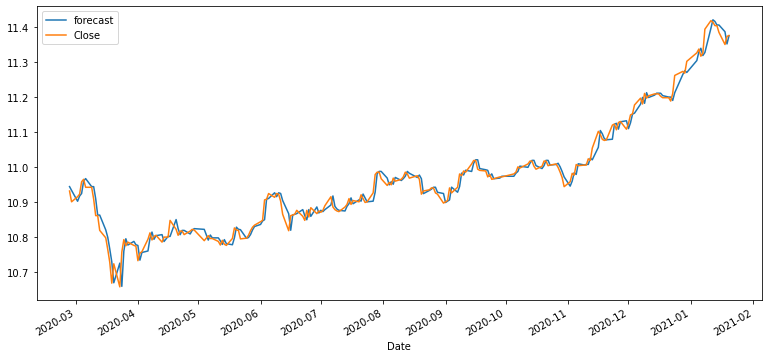

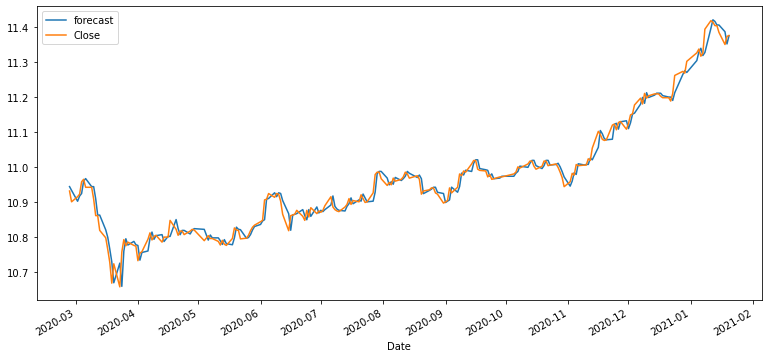

In [46]:
fitted_m.plot_predict()

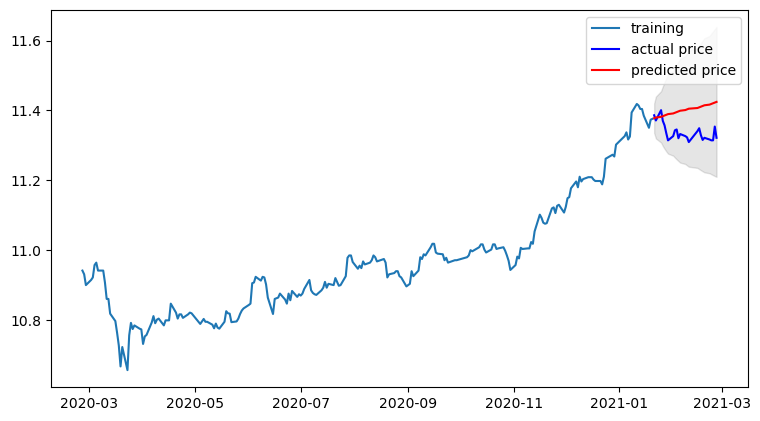

In [47]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [48]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  38996042.016549595
MAE:  5681.044578111961
RMSE:  6244.681098066545
MAPE: 6.84%


오차율 0.01% 감소..ㅡ_ㅡ

### 미래 주식을 예측해보자

In [49]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
#print(final_data)


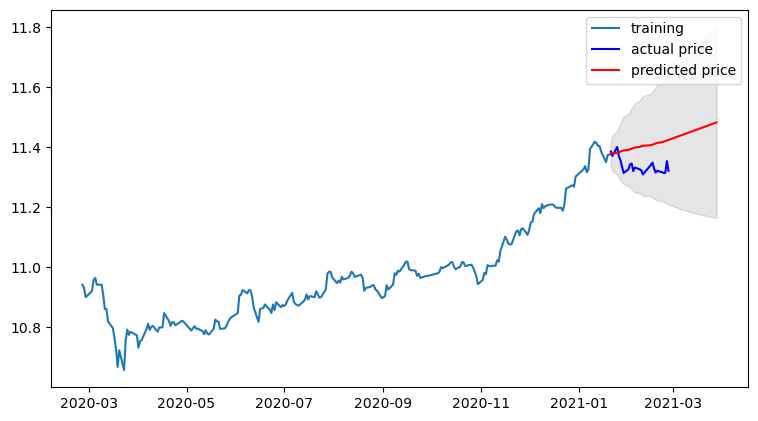

In [50]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [51]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound


In [52]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])

fore_series

,Close
2021-02-27,87367.336327
2021-02-28,87535.955069
2021-03-01,87705.464921
2021-03-02,87875.635892
2021-03-03,88046.332918
2021-03-04,88217.476786
2021-03-05,88389.021150
2021-03-06,88560.939006
2021-03-07,88733.214733
2021-03-08,88905.839405


In [53]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 540.303
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -1070.606
Time:                        02:44:50   BIC                          -1053.570
Sample:                             1   HQIC                         -1063.728
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.002      1.268      0.205      -0.001       0.005
ar.L1.D.Close    -0.0362      0.534     -0.068      0.946      -1.083       1.010
ma.L1.D.Close     0.0183      0.530     

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

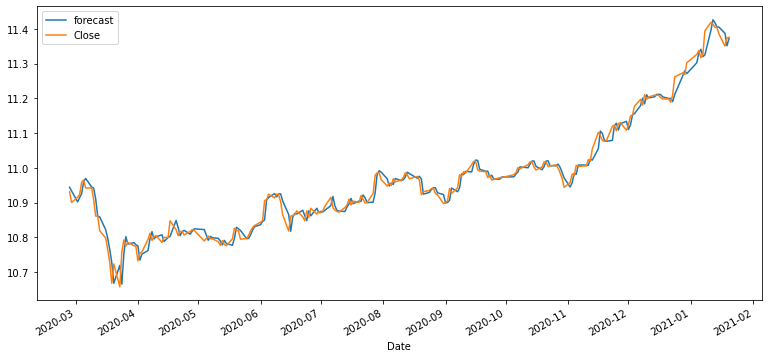

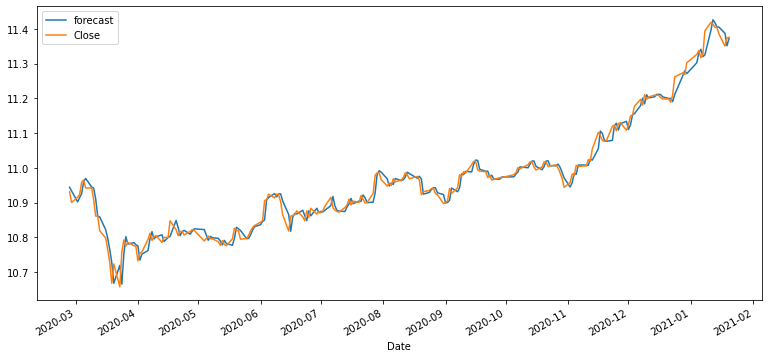

In [54]:
fitted_m.plot_predict()

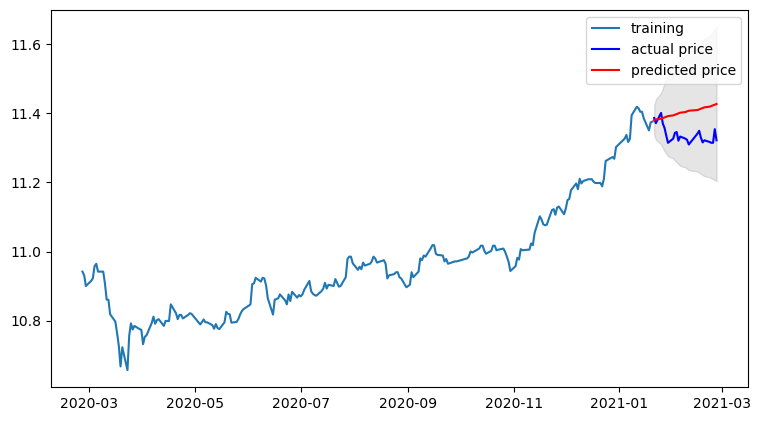

In [55]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [56]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  41232685.84547678
MAE:  5850.08118551838
RMSE:  6421.2682427598975
MAPE: 7.04%


### 미래 주식을 예측해보자

In [57]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
#print(final_data)


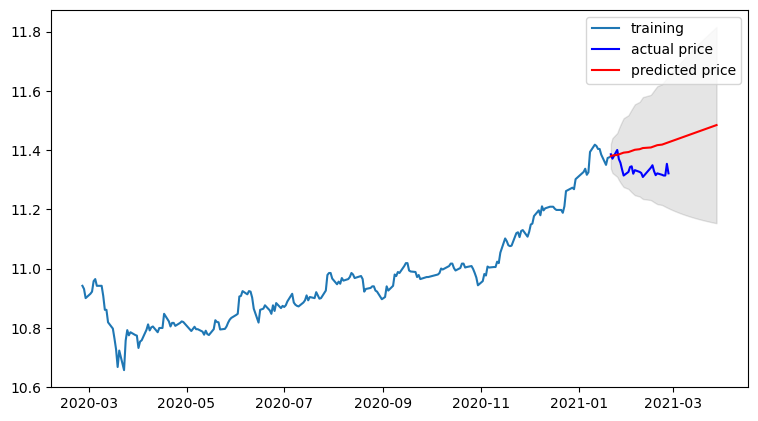

In [58]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [59]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound

In [60]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])
fore_series

,Close
2021-02-27,87542.020110
2021-02-28,87734.878101
2021-03-01,87904.368606
2021-03-02,88075.048228
2021-03-03,88246.028039
2021-03-04,88417.340903
2021-03-05,88588.986297
2021-03-06,88760.964909
2021-03-07,88933.277385
2021-03-08,89105.924373


In [61]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 3))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 540.520
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -1069.041
Time:                        02:44:51   BIC                          -1048.598
Sample:                             1   HQIC                         -1060.788
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      2.086      0.037       0.000       0.004
ar.L1.D.Close     0.9892      0.020     50.441      0.000       0.951       1.028
ma.L1.D.Close    -1.0126      0.069    -

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


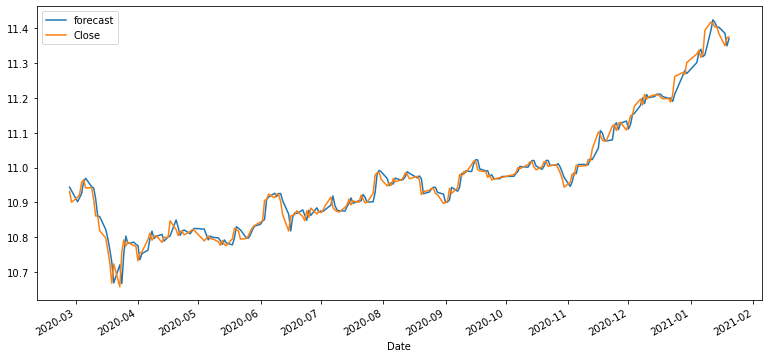

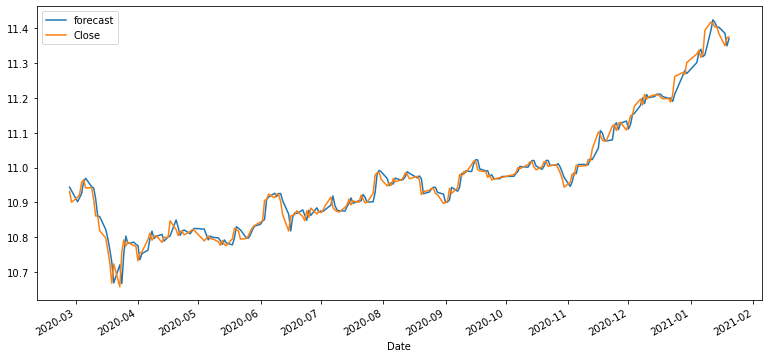

In [62]:
fitted_m.plot_predict()

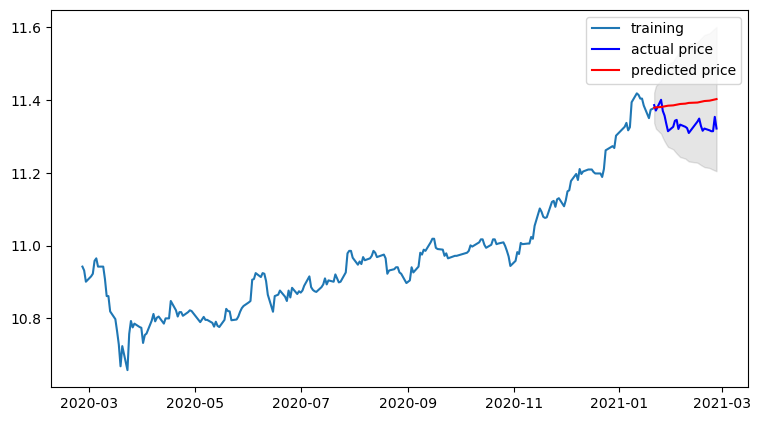

In [63]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [64]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26681780.56896224
MAE:  4731.513092339487
RMSE:  5165.440984946226
MAPE: 5.69%


### 미래 주식을 예측해보자

In [65]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
#print(final_data)


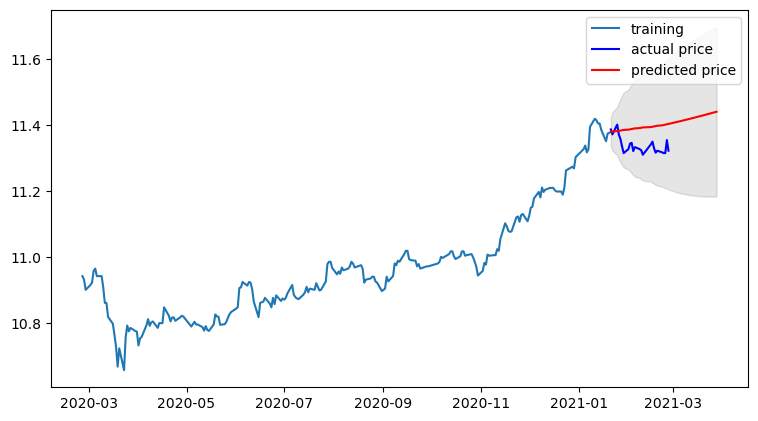

In [66]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [67]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound

In [68]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])
fore_series

,Close
2021-02-27,87455.893355
2021-02-28,87570.166078
2021-03-01,87645.781328
2021-03-02,87722.516877
2021-03-03,87800.364155
2021-03-04,87879.314718
2021-03-05,87959.360247
2021-03-06,88040.492542
2021-03-07,88122.703521
2021-03-08,88205.985222


오오..!

In [69]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 4))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 540.521
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -1067.041
Time:                        02:44:52   BIC                          -1043.191
Sample:                             1   HQIC                         -1057.413
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      2.082      0.037       0.000       0.004
ar.L1.D.Close     0.9893      0.020     49.291      0.000       0.950       1.029
ma.L1.D.Close    -1.0129      0.070    -

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


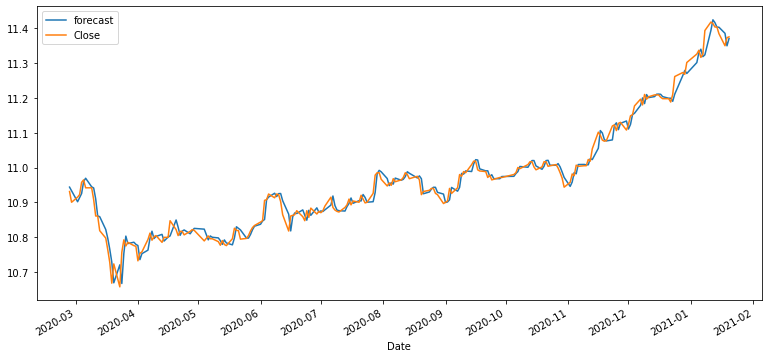

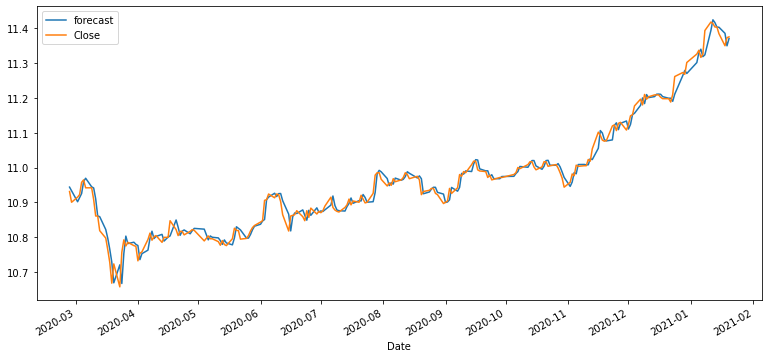

In [70]:
fitted_m.plot_predict()

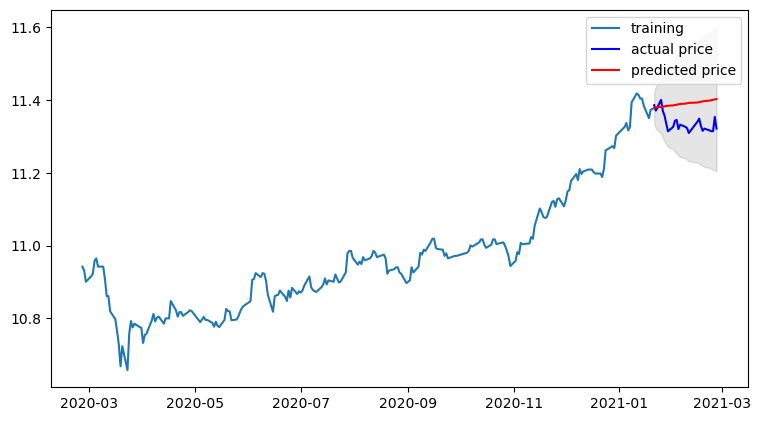

In [71]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [72]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26845652.198995966
MAE:  4745.724969394013
RMSE:  5181.279011884611
MAPE: 5.71%


q를 바꿔가며 돌려본 결과 q=3일 때 가장 오차율이 적었습니다.

### 미래 주식을 예측해보자

In [73]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
#print(final_data)


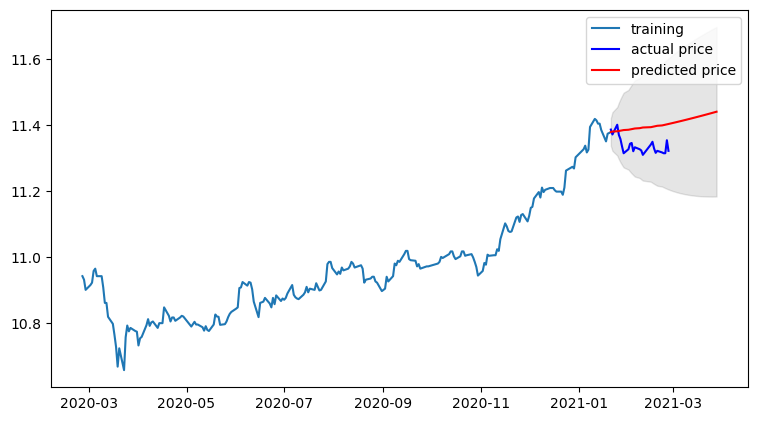

In [74]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [75]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound

In [76]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])
fore_series

,Close
2021-02-27,87461.510931
2021-02-28,87573.657713
2021-03-01,87649.846178
2021-03-02,87727.787649
2021-03-03,87806.820671
2021-03-04,87886.937126
2021-03-05,87968.129012
2021-03-06,88050.388444
2021-03-07,88133.707648
2021-03-08,88218.078965


## 7. 다른 주식 종목 예측해 보기

### 1. SK 하이닉스

In [77]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/E13_TimeSeriesPrediction/data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']    # 종가만 가져옵니다

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-03-02    92100.0
2020-03-03    92800.0
2020-03-04    94300.0
2020-03-05    94900.0
2020-03-06    92600.0
Name: Close, dtype: float64

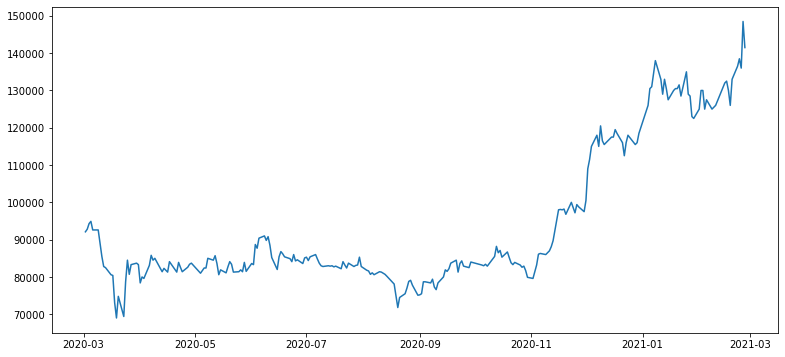

In [78]:
# 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

In [79]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [80]:
# 로그변환 - 시간 추이에 따라 분산이 점점 커지고 있을 때는 로그변환을 해주면 좋습니다.
ts_log = np.log(ts)

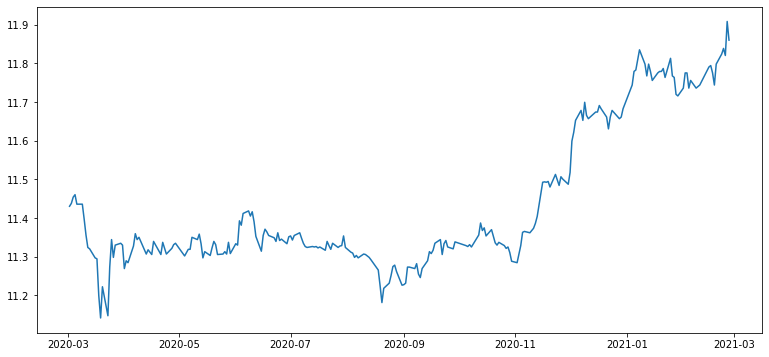

In [81]:
plt.plot(ts_log)

In [82]:
# 일정 시간 내 구간 통계치를 시각화해보기

def plot_rolling_statistics(timeseries, window=12):
    
    # 현재 타임스텝 ~ window에 주어진 타임스텝 이전 사이 구간의 평균, 표준편차
    rolmean = timeseries.rolling(window=window).mean()       # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std()         # 이동 표준편차 시계열
    
    # 원본 시계열, 이동 평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

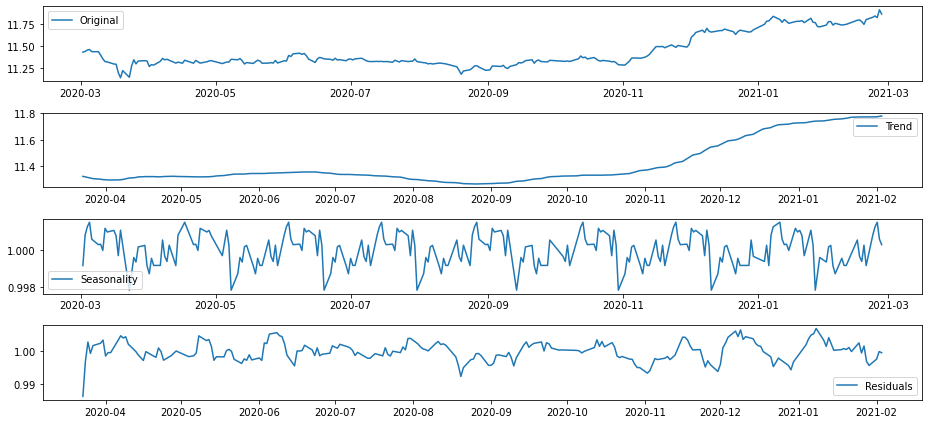

In [83]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')        # Residual = trend와 Seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

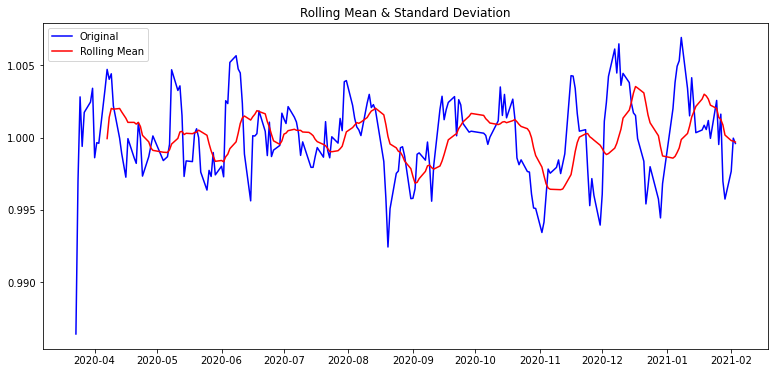

In [84]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [85]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.576435
p-value                          0.000001
#Lags Used                       2.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


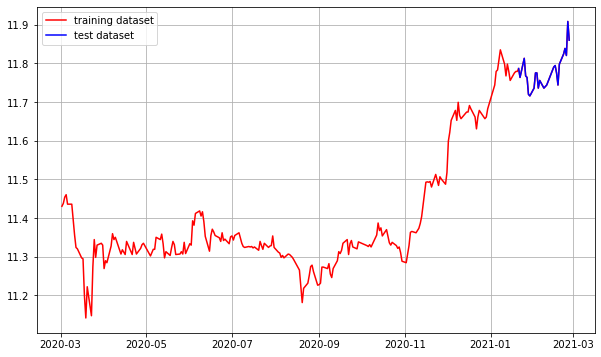

In [86]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [87]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-03-02    11.430630
2020-03-03    11.438202
Name: Close, dtype: float64
(221,)
(25,)


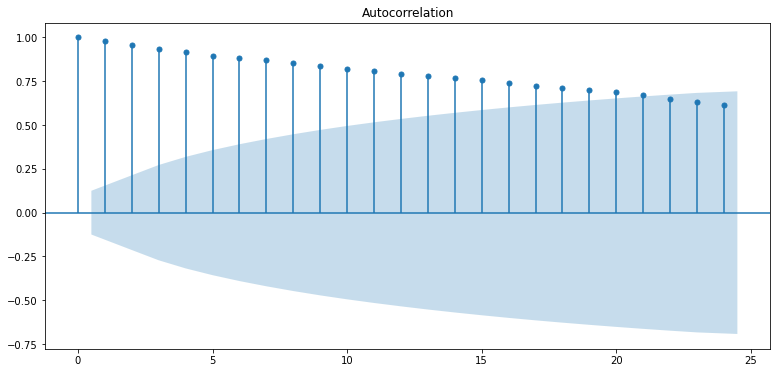

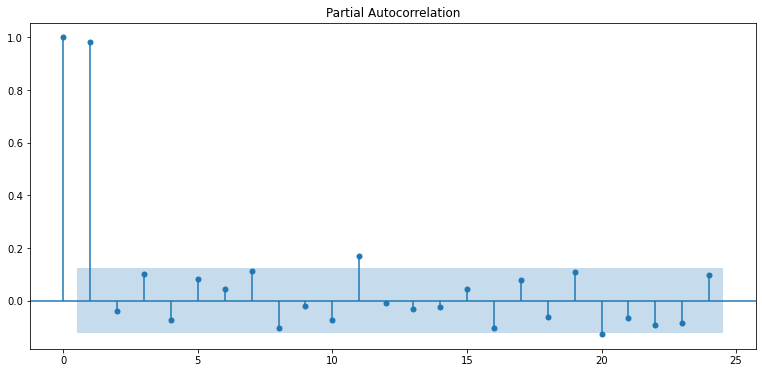

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.667083e+01
p-value                        1.545461e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


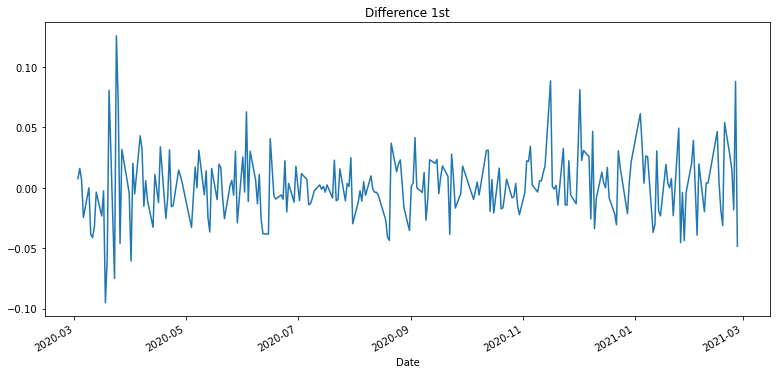

In [89]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

p =  1,  d = 1  q = 0

In [90]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 487.362
Method:                       css-mle   S.D. of innovations              0.026
Date:                Tue, 02 Mar 2021   AIC                           -968.724
Time:                        02:44:54   BIC                           -958.543
Sample:                             1   HQIC                          -964.613
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.002      0.916      0.359      -0.002       0.005
ar.L1.D.Close    -0.0304      0.067     -0.452      0.651      -0.162       0.101
                                    Root

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

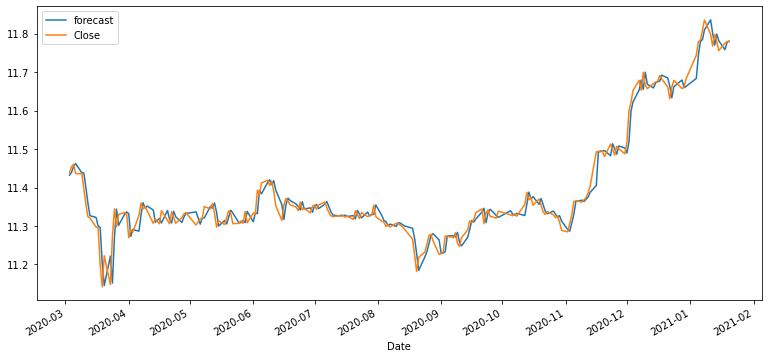

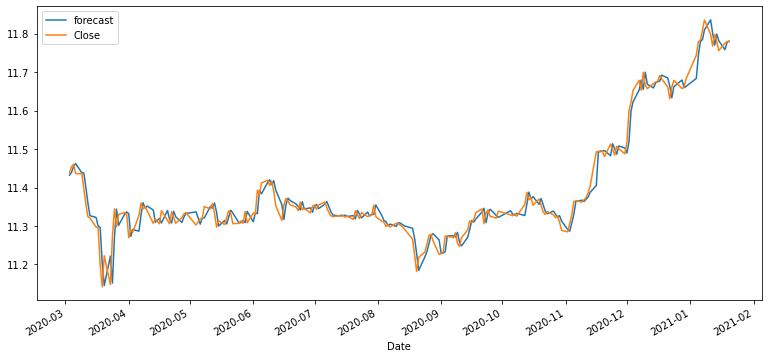

In [91]:
fitted_m.plot_predict()

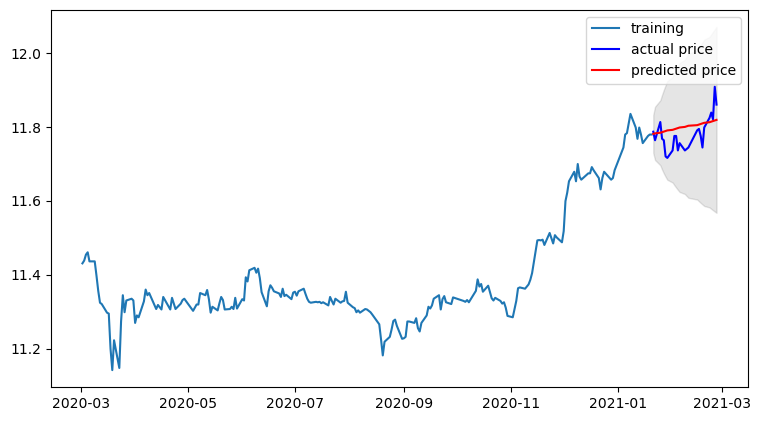

In [92]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [93]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34392844.60997056
MAE:  4883.0461773471825
RMSE:  5864.541295785252
MAPE: 3.77%


### 미래 주식을 예측해보자

In [94]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])


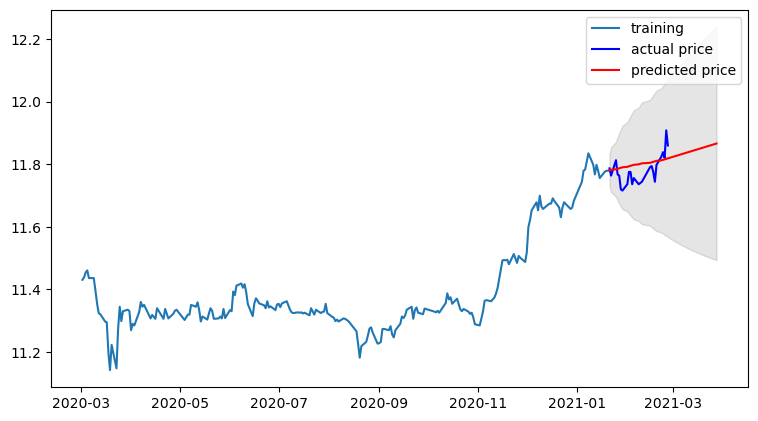

In [95]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [96]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound


In [97]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])

fore_series

,Close
2021-02-27,130713.095605
2021-02-28,130920.050857
2021-03-01,131127.531161
2021-03-02,131335.334273
2021-03-03,131543.466881
2021-03-04,131751.929320
2021-03-05,131960.722118
2021-03-06,132169.845800
2021-03-07,132379.300888
2021-03-08,132589.087908


### 2.  Shilla Hotel

In [98]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/E13_TimeSeriesPrediction/data/008775.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']    # 종가만 가져옵니다

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-03-02    54200.0
2020-03-03    55100.0
2020-03-04    56000.0
2020-03-05    56500.0
2020-03-06    56300.0
Name: Close, dtype: float64

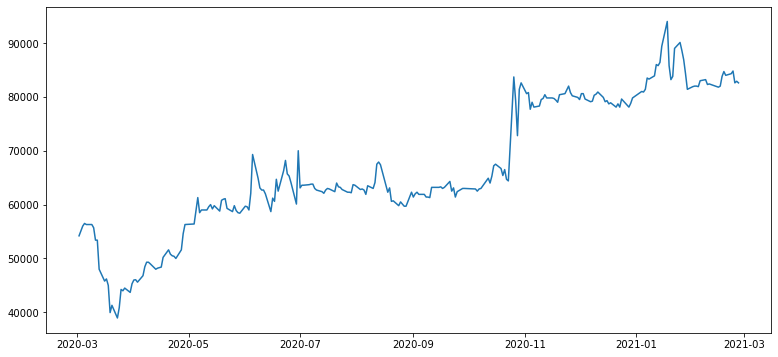

In [99]:
# 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

In [100]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [101]:
# 로그변환 - 시간 추이에 따라 분산이 점점 커지고 있을 때는 로그변환을 해주면 좋습니다.
ts_log = np.log(ts)

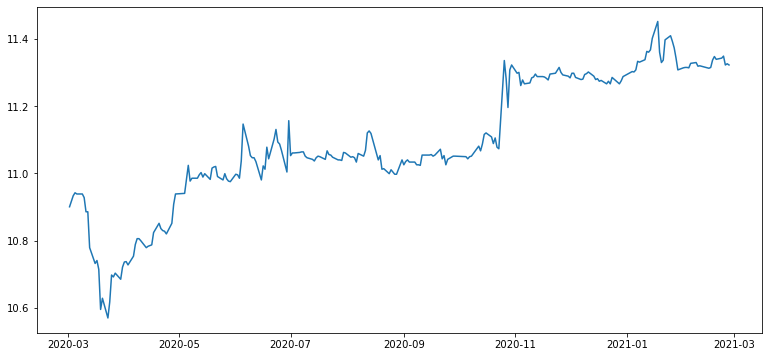

In [102]:
plt.plot(ts_log)

In [103]:
# 일정 시간 내 구간 통계치를 시각화해보기

def plot_rolling_statistics(timeseries, window=12):
    
    # 현재 타임스텝 ~ window에 주어진 타임스텝 이전 사이 구간의 평균, 표준편차
    rolmean = timeseries.rolling(window=window).mean()       # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std()         # 이동 표준편차 시계열
    
    # 원본 시계열, 이동 평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

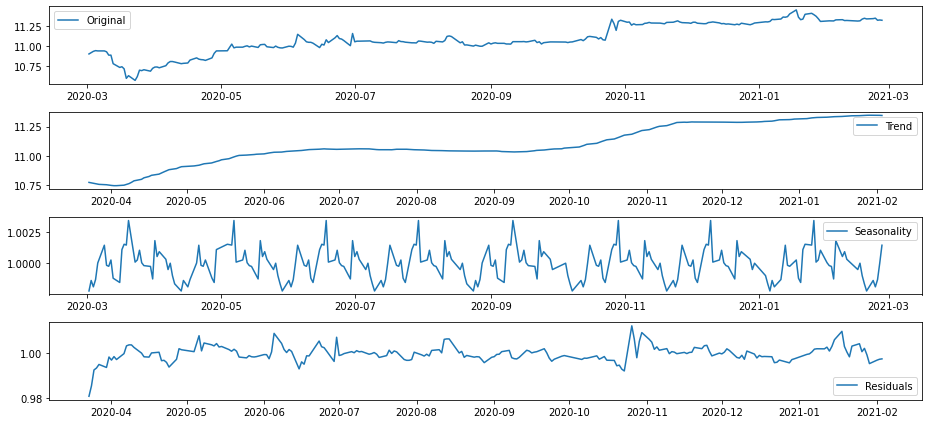

In [104]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')        # Residual = trend와 Seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

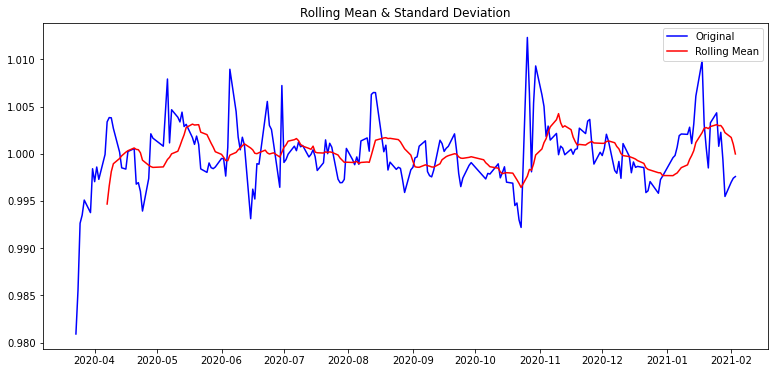

In [105]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [106]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.219685e+00
p-value                        6.480052e-13
#Lags Used                     0.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


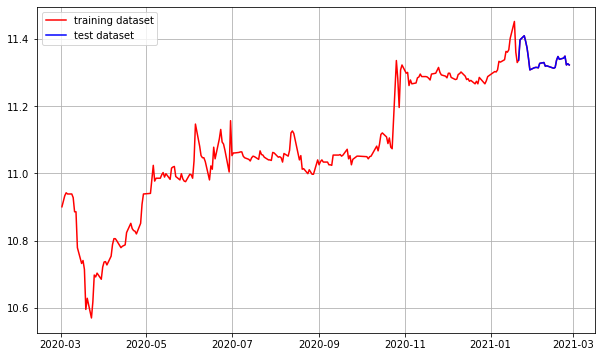

In [107]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [108]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-03-02    10.900436
2020-03-03    10.916905
Name: Close, dtype: float64
(221,)
(25,)


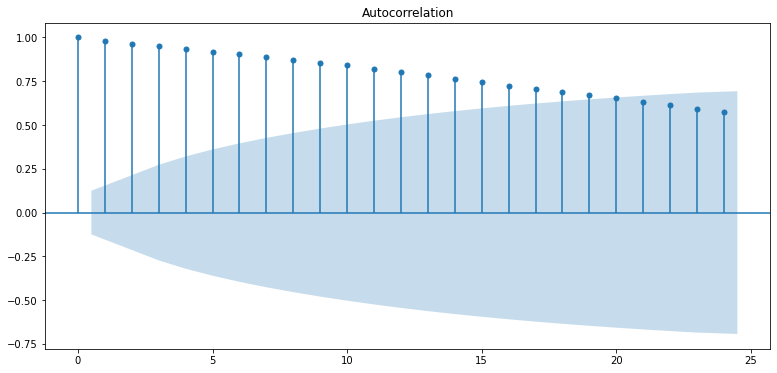

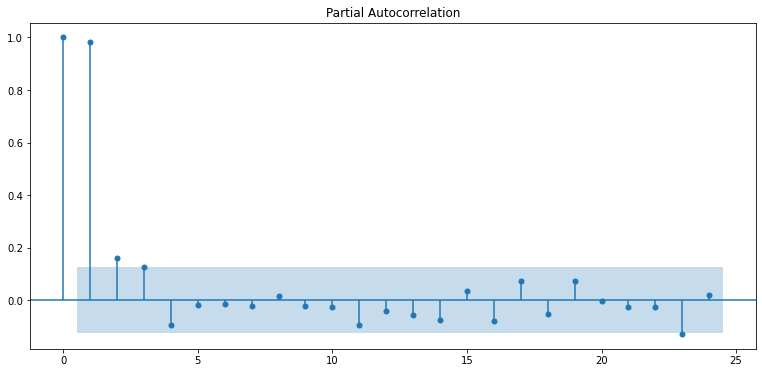

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.360239e+01
p-value                        1.941942e-25
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


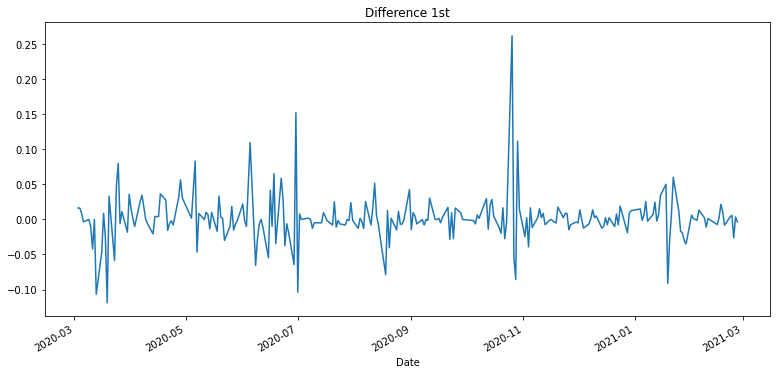

In [110]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [111]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(3, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 428.645
Method:                       css-mle   S.D. of innovations              0.034
Date:                Tue, 02 Mar 2021   AIC                           -847.289
Time:                        02:44:56   BIC                           -830.321
Sample:                             1   HQIC                          -840.437
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.002      1.040      0.298      -0.002       0.006
ar.L1.D.Close    -0.2038      0.067     -3.030      0.002      -0.336      -0.072
ar.L2.D.Close    -0.1169      0.069     

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

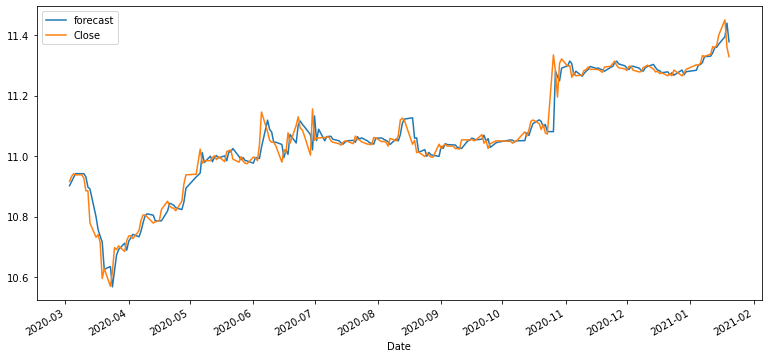

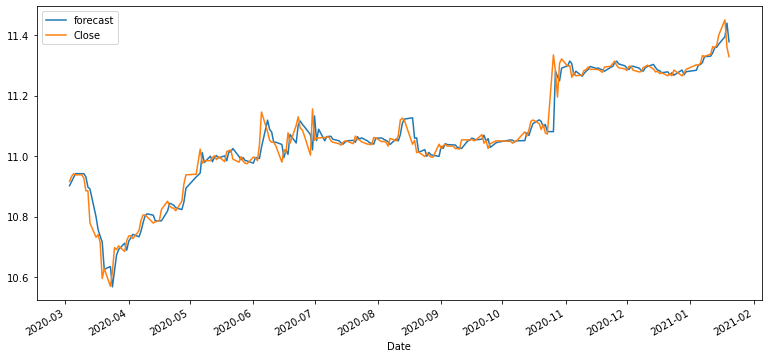

In [112]:
fitted_m.plot_predict()

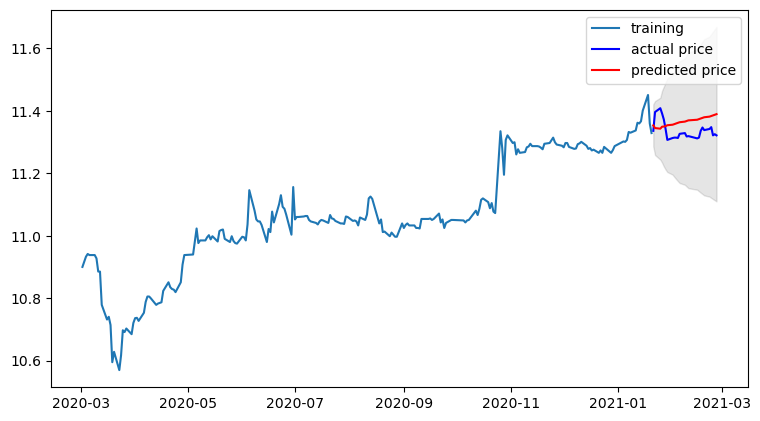

In [113]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [114]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15755248.09761755
MAE:  3774.00046307024
RMSE:  3969.2881096762867
MAPE: 4.51%


### 미래 주식을 예측해보자

In [115]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
#print(final_data)


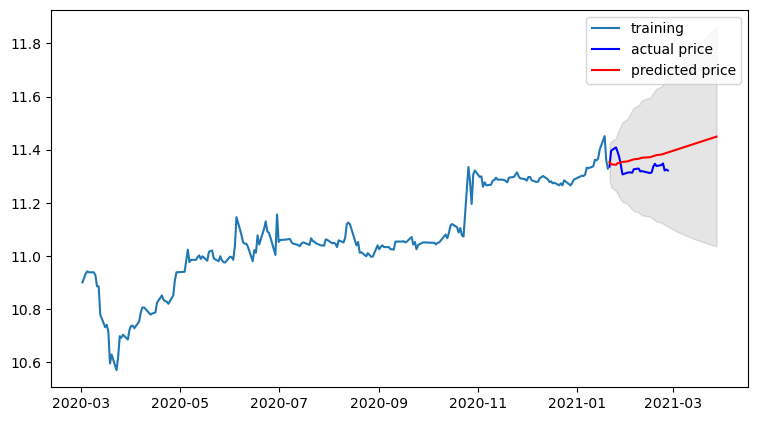

In [116]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [117]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound


In [118]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])

fore_series


,Close
2021-02-27,85272.628741
2021-02-28,84547.383799
2021-03-01,84383.940749
2021-03-02,84924.289891
2021-03-03,84962.526500
2021-03-04,85079.639114
2021-03-05,85314.071403
2021-03-06,85462.898738
2021-03-07,85624.131750
2021-03-08,85805.631568


In [119]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(3, 1, 3))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 428.838
Method:                       css-mle   S.D. of innovations              0.034
Date:                Tue, 02 Mar 2021   AIC                           -841.675
Time:                        02:44:57   BIC                           -814.526
Sample:                             1   HQIC                          -830.712
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.002      0.995      0.320      -0.002       0.006
ar.L1.D.Close    -0.1084      0.571     -0.190      0.849      -1.228       1.011
ar.L2.D.Close    -0.1695      0.329     

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


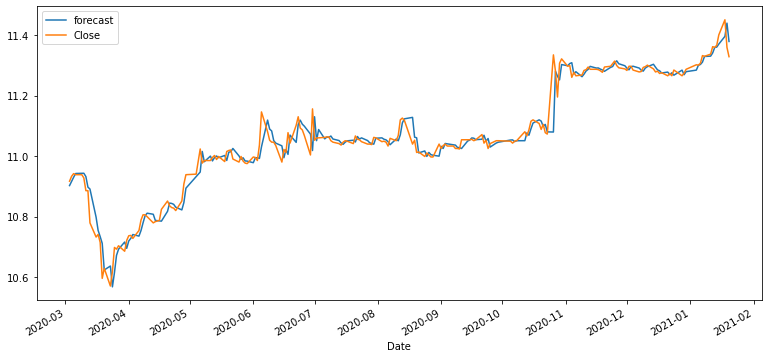

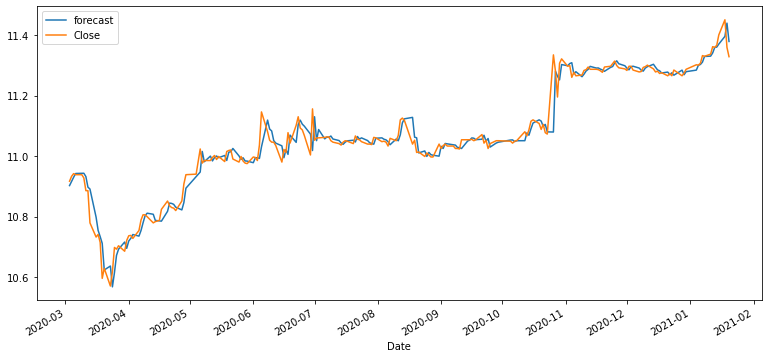

In [120]:
fitted_m.plot_predict()

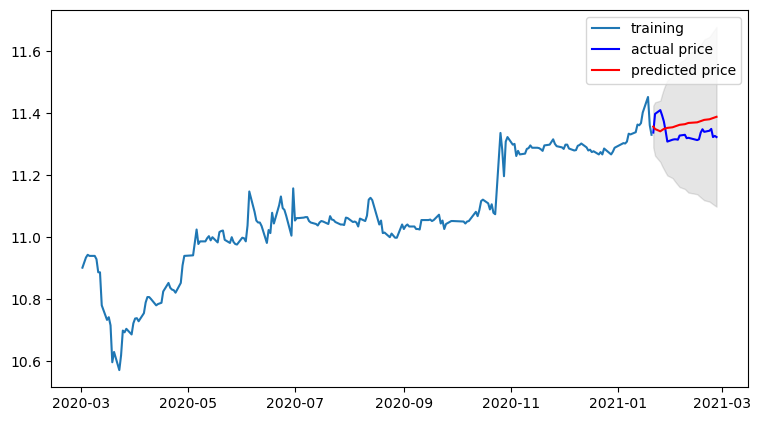

In [121]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [122]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14667733.848189713
MAE:  3633.895272003751
RMSE:  3829.8477578344696
MAPE: 4.34%


In [123]:
date_idx = pd.DatetimeIndex(pd.date_range("2021-2-27",periods=30))

# testTimes
add_data = pd.DataFrame(index = date_idx)
final_data = pd.concat([test_data ,add_data])
#print(final_data)

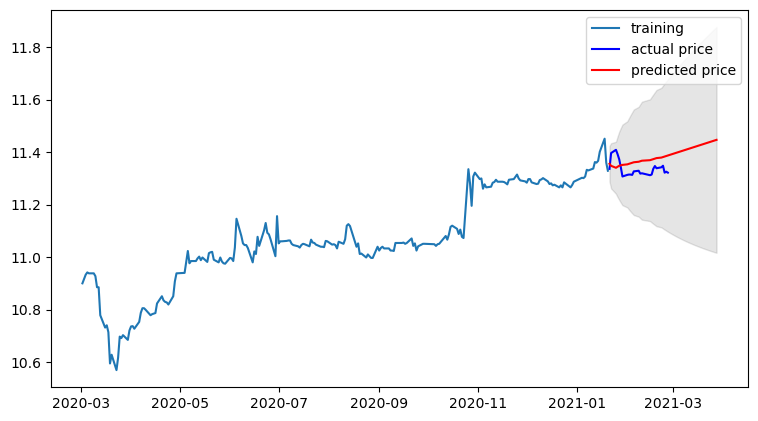

In [124]:
# Forecast : 결과가 fc에 담깁니다. 

fc, se, conf = fitted_m.forecast(len(final_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = final_data.index )   # 예측결과
lower_series = pd.Series(conf[:, 0], index=final_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=final_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [125]:
fore = fitted_m.forecast(steps = 30) # 예측값, stderr, upperbound, lowerbound

In [126]:
fore_series = pd.DataFrame(np.exp(fore[0]), index = date_idx, columns=['Close'])

fore_series


,Close
2021-02-27,85432.242594
2021-02-28,84767.476905
2021-03-01,84145.178773
2021-03-02,84475.167453
2021-03-03,84784.646452
2021-03-04,84933.902521
2021-03-05,85075.487883
2021-03-06,85246.257090
2021-03-07,85420.497064
2021-03-08,85590.068159


## [결론 및 회고]